# Finetune EfficientNet

<div>
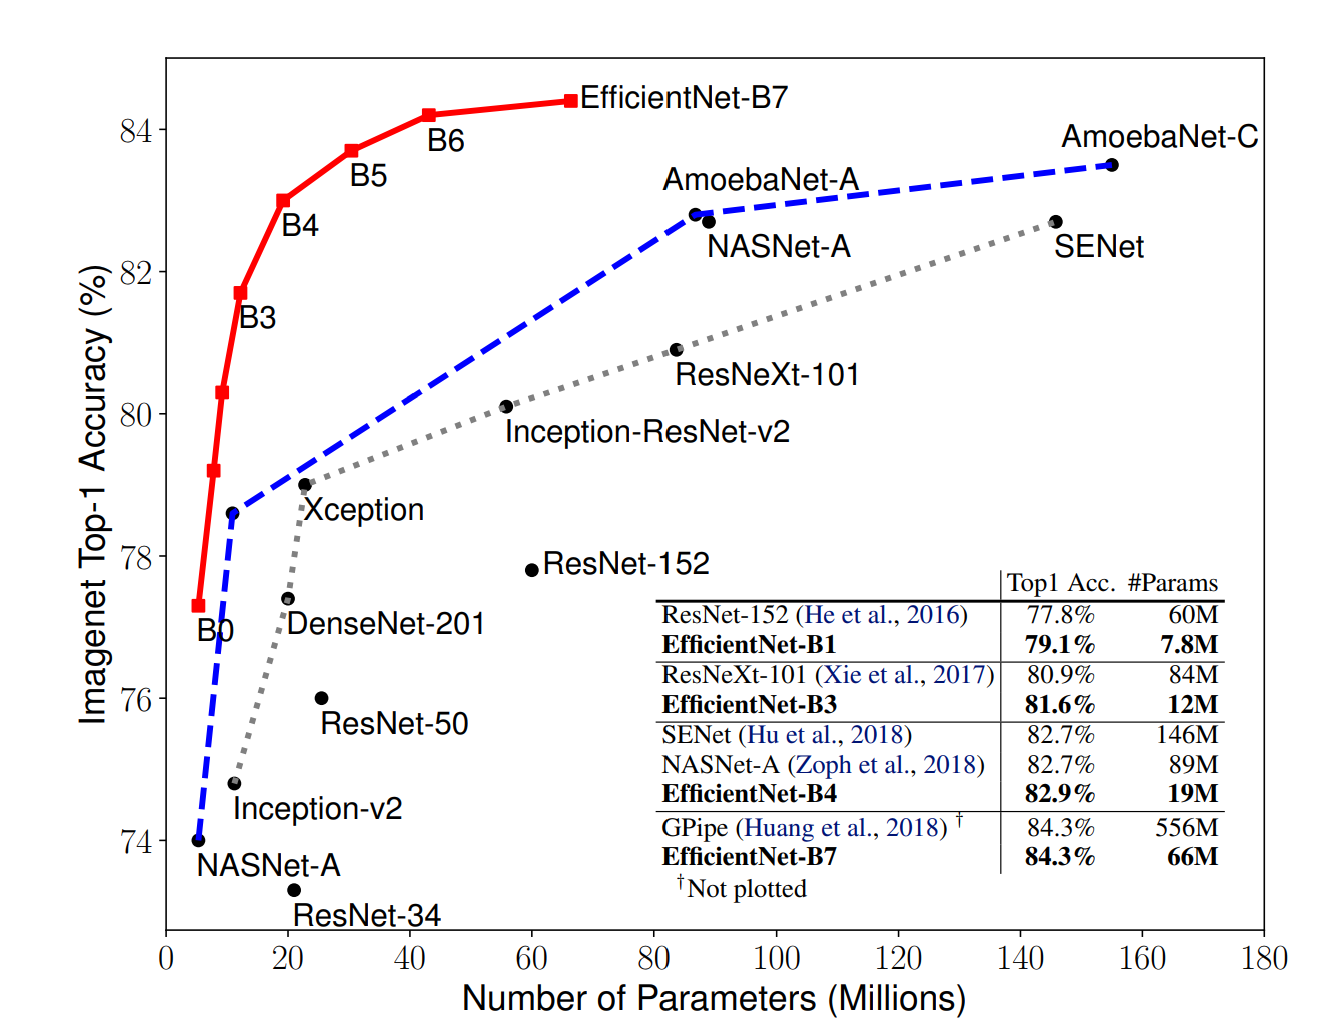
</div>

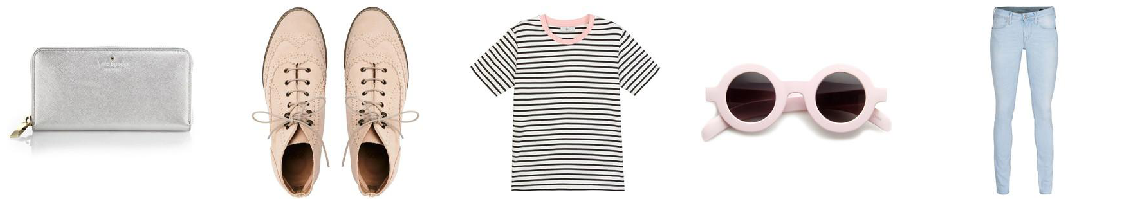

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
from collections import Counter
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from tqdm import tqdm
import pickle

import sys
sys.path.insert(0, "/recsys_data/RecSys/fashion/automl/efficientnetv2")
import effnetv2_model

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="finetune-efficientnet")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aeroabir. Use `wandb login --relogin` to force relogin


In [3]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
train_dir = os.path.join(base_dir, "disjoint")
image_dir = os.path.join(base_dir, "images")
train_json = "train.json"
train_file = "compatibility_train.txt"
item_file = "polyvore_item_metadata.json"
outfit_file = "polyvore_outfit_titles.json"

In [4]:
with open(os.path.join(base_dir, item_file), 'r') as fr:
    pv_items = json.load(fr)
print(f"There are {len(pv_items)} items")

There are 251008 items


In [5]:
from data_process import ImageDataGen

In [6]:
batch_size = 128
train_gen = ImageDataGen(pv_items, image_dir, batch_size=batch_size)
valid_gen = ImageDataGen(pv_items, image_dir, batch_size=batch_size, valid=True, valid_sample=10000)
# x, y = train_gen[0]
# x.shape, y.shape

Total 251008 images with 153 classes
Total 10000 images with 132 classes


In [8]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
#     effnetv2_model.get_model('efficientnetv2-b0', include_top=False),
#     tf.keras.layers.Dropout(rate=0.2),
#     tf.keras.layers.Dense(153, activation='softmax'),
# ])

# 21.8 million
# model = tf.keras.applications.InceptionV3(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=[224, 224, 3],
#     pooling=None,
#     classes=153,
#     classifier_activation="softmax",
# )

# 54 million
model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=[224, 224, 3],
    pooling=None,
    classes=153,
    classifier_activation="softmax",
)
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_119 (BatchN (None, 12, 12, 192)  576         conv2d_119[0][0]                 
__________________________________________________________________________________________________
activation_116 (Activation)     (None, 12, 12, 192)  0           batch_normalization_116[0][0]    
__________________________________________________________________________________________________
activation_119 (Activation)     (None, 12, 12, 192)  0           batch_normalization_119[0][0]    
__________________________________________________________________________________________________
block17_11_mixed (Concatenate)  (None, 12, 12, 384)  0           activation_116[0][0]             
                                                                 activation_119[0][0]             
__________________________________________________________________________________________________
block17_11

block17_17 (Lambda)             (None, 12, 12, 1088) 0           block17_16_ac[0][0]              
                                                                 block17_17_conv[0][0]            
__________________________________________________________________________________________________
block17_17_ac (Activation)      (None, 12, 12, 1088) 0           block17_17[0][0]                 
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 12, 12, 128)  139264      block17_17_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_145 (BatchN (None, 12, 12, 128)  384         conv2d_145[0][0]                 
__________________________________________________________________________________________________
activation_145 (Activation)     (None, 12, 12, 128)  0           batch_normalization_145[0][0]    
__________

__________________________________________________________________________________________________
block8_4_ac (Activation)        (None, 5, 5, 2080)   0           block8_4[0][0]                   
__________________________________________________________________________________________________
conv2d_180 (Conv2D)             (None, 5, 5, 192)    399360      block8_4_ac[0][0]                
__________________________________________________________________________________________________
batch_normalization_180 (BatchN (None, 5, 5, 192)    576         conv2d_180[0][0]                 
__________________________________________________________________________________________________
activation_180 (Activation)     (None, 5, 5, 192)    0           batch_normalization_180[0][0]    
__________________________________________________________________________________________________
conv2d_181 (Conv2D)             (None, 5, 5, 224)    129024      activation_180[0][0]             
__________

Total params: 54,336,736
Trainable params: 54,276,192
Non-trainable params: 60,544
__________________________________________________________________________________________________


In [ ]:
learning_rate = 1.0e-03
epochs = 100
patience = 20
monitor = "val_loss"
num_train = 251008
checkpoint_filepath = base_dir + '/checkpoint'

opt = keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="auto", name="sparse_categorical_crossentropy"
)
model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
callback = EarlyStopping(
                        monitor="val_accuracy",
                        min_delta=0,
                        patience=patience,
                        verbose=0,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=True,
                    )

wandb_callback = WandbCallback(
                        monitor=monitor,
                        verbose=0,
                        save_model=(False), 
                        mode="auto")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

tic = time.time()
history = model.fit(train_gen, 
                    epochs=epochs, 
                    batch_size=batch_size,
#                     steps_per_epoch=math.ceil(251008./batch_size),
                    validation_data=valid_gen,
                    callbacks=[callback, model_checkpoint_callback, wandb_callback],
                    verbose=1)
time.time() - tic

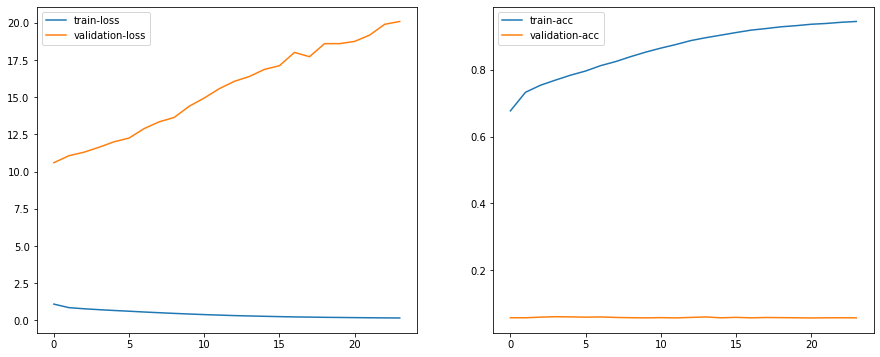

In [11]:
f, axs = plt.subplots(1,2,figsize=(15,6))
plt.subplot(121)
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='validation-loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='train-acc')
plt.plot(history.history['val_accuracy'], label='validation-acc')
plt.legend()

In [12]:
x, y = valid_gen[0]

In [16]:
np.argmax(model(x), 1) == y

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False,  True, False,
       False, False]

In [15]:
y

array([  0,  22,  40,  20,  14,   7,   3,  73,  31,  30,   4,  27,  29,
        30,  80,  20,  30,  15,  23,  20,  27,  28,  19,  20,  89,  23,
        19,  29,  20,  29,  49,  36,   5,  82,  27,  14,  10,  14,  45,
         2,  36,   2,  45,  62,   7,  11,  63,   0,  10,  15,  73,  27,
         7,  34,   5,  53,  29,  31,  17,  24,  50,  31,  77,  23,  21,
        21,  44,  29,  34,   3,  23,  74,  40,  17,  31, 118,  53,   4,
        32,  79,   3,  48,   6,  28,  33,  30,  89,   4,  71,  17,  20,
        27,  25,  14,  40,  31,  63,  33,  27,  58,  46,  14,  25,  27,
        79,  26,   7,  68,  10,   7,  30,  79,  14,  48,  55,  46,  35,
        16,  29,   0,   0,  55,  31,   3,  27,  21,   5,  29])

In [7]:
model = keras.models.load_model("finetuned_efficientnet")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetv2-b0 (EffNetV2M (None, 1280)              5919312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 153)               195993    
Total params: 6,115,305
Trainable params: 6,054,697
Non-trainable params: 60,608
_________________________________________________________________


In [31]:
m = tf.keras.metrics.SparseCategoricalAccuracy()
acc_list = []
pbar = tqdm(range(len(train_gen)))
for ii in pbar:
    x, y = train_gen[ii]  # batch size
    yhat = model(x)
#     yhat = np.argmax(yhat, axis=1)
    m.update_state(y, yhat)
    batch_acc = m.result().numpy()
    acc_list.append(batch_acc)
    pbar.set_description("Batch accuracy %g" % batch_acc)
    m.reset_state()
#     print(batch_acc)

Batch accuracy 0.742188:   0%|          | 0/1961 [00:00<?, ?it/s]


AttributeError: 'SparseCategoricalAccuracy' object has no attribute 'reset_state'

In [30]:
np.mean(acc_list)

0.73729026

In [32]:
model.layers.pop()

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetv2-b0 (EffNetV2M (None, 1280)              5919312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 153)               195993    
Total params: 6,115,305
Trainable params: 6,054,697
Non-trainable params: 60,608
_________________________________________________________________


In [34]:
model.layers

In [35]:
new_model = tf.keras.models.Sequential(
                [tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
                 model.layers[0]])
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetv2-b0 (EffNetV2M (None, 1280)              5919312   
Total params: 5,919,312
Trainable params: 5,858,704
Non-trainable params: 60,608
_________________________________________________________________


In [36]:
new_model(x)

<tf.Tensor: shape=(128, 1280), dtype=float32, numpy=
array([[-0.07364747,  0.07855991,  0.16616759, ...,  0.06713746,
        -0.09063803,  1.0425735 ],
       [ 1.3108509 ,  0.36213812,  0.3086262 , ...,  0.10953063,
        -0.12269413, -0.14525886],
       [-0.08061856, -0.10835455, -0.09532554, ..., -0.00621533,
        -0.12571202, -0.10655893],
       ...,
       [-0.135448  ,  0.01326273, -0.19697645, ...,  0.20553531,
        -0.09345884,  0.24549763],
       [-0.0757052 , -0.03442678, -0.04213793, ...,  1.1465435 ,
        -0.0414162 , -0.09319429],
       [-0.10675253, -0.0941774 ,  0.23157725, ...,  0.11878272,
         0.48191762, -0.08288536]], dtype=float32)>